## Project 2 - Finance

#### DESCRIPTION

#### Problem Statement

Finance Industry is the biggest consumer of Data Scientists. It faces constant attack by fraudsters, who try to trick the system. Correctly identifying fraudulent transactions is often compared with finding needle in a haystack because of the low event rate. 
It is important that credit card companies are able to recognize fraudulent credit card transactions so that the customers are not charged for items that they did not purchase.
You are required to try various techniques such as supervised models with oversampling, unsupervised anomaly detection, and heuristics to get good accuracy at fraud detection.

#### Dataset Snapshot

The datasets contain transactions made by credit cards in September 2013 by European cardholders. This dataset represents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.
It contains only numerical input variables which are the result of a PCA transformation. 
Features V1, V2, ... V28 are the principal components obtained with PCA. 
The only features which have not been transformed with PCA are 'Time' and 'Amount'

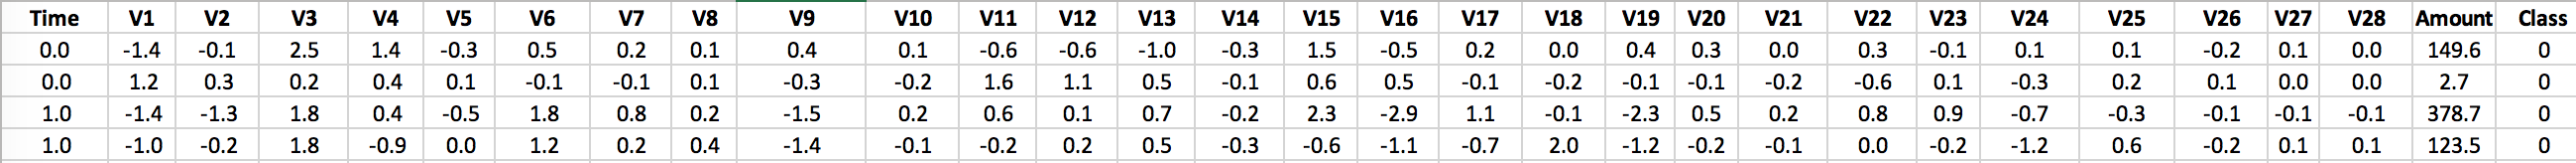

Download the data set from [here](https://www.dropbox.com/s/6z5jxcqaqipxiun/Project%202-Finance-Datasets.zip?dl=0 )

In [1]:
# import required libraries/modules
import pandas as pd
import numpy as np
import seaborn as sns
import base64, io, IPython

from PIL import Image as PILImage

from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score

from imblearn.pipeline import Pipeline as imPipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.ioff()

In [2]:
# helper functions for this notebook
def display_image(path):
    img = PILImage.open(path)
    out = io.BytesIO()
    img.save(out, format='PNG')
    enc_str = base64.b64encode(out.getvalue()).decode()
    html = f'<img src="data:image/png;base64,{enc_str}" />'
    return IPython.display.HTML(html)

#### Project Task: Week 1

#### Exploratory Data Analysis (EDA)

1. Perform an EDA on the Dataset.
   1. Check all the latent features and parameters with their mean and standard deviation. Value are close to 0 centered (mean) with unit standard deviation
   2. Find if there is any connection between Time, Amount, and the transaction being fraudulent.
2. Check the class count for each class. It’s a class Imbalance problem.
3. Use techniques like undersampling or oversampling before running Naïve Bayes, Logistic Regression or SVM.
   1. Oversampling or undersampling can be used to tackle the class imbalance problem
   2. Oversampling increases the prior probability of imbalanced class and in case of other classifiers, error gets multiplied as the low-proportionate class is mimicked multiple times.
4. Following are the matrices for evaluating the model performance: Precision, Recall, F1-Score, AUC-ROC curve. Use F1-Score as the evaluation criteria for this project.

In [3]:
# V colums
pca_vars = ['V%i' % k for k in range(1,29)]

In [4]:
# load train data
train_df = pd.read_csv('./Financial/train_data.csv')
test_df = pd.read_csv('./Financial/test_data_hidden.csv')

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227845 entries, 0 to 227844
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    227845 non-null  float64
 1   V1      227845 non-null  float64
 2   V2      227845 non-null  float64
 3   V3      227845 non-null  float64
 4   V4      227845 non-null  float64
 5   V5      227845 non-null  float64
 6   V6      227845 non-null  float64
 7   V7      227845 non-null  float64
 8   V8      227845 non-null  float64
 9   V9      227845 non-null  float64
 10  V10     227845 non-null  float64
 11  V11     227845 non-null  float64
 12  V12     227845 non-null  float64
 13  V13     227845 non-null  float64
 14  V14     227845 non-null  float64
 15  V15     227845 non-null  float64
 16  V16     227845 non-null  float64
 17  V17     227845 non-null  float64
 18  V18     227845 non-null  float64
 19  V19     227845 non-null  float64
 20  V20     227845 non-null  float64
 21  V21     22

#### 1.0 Perform an EDA on the Dataset.


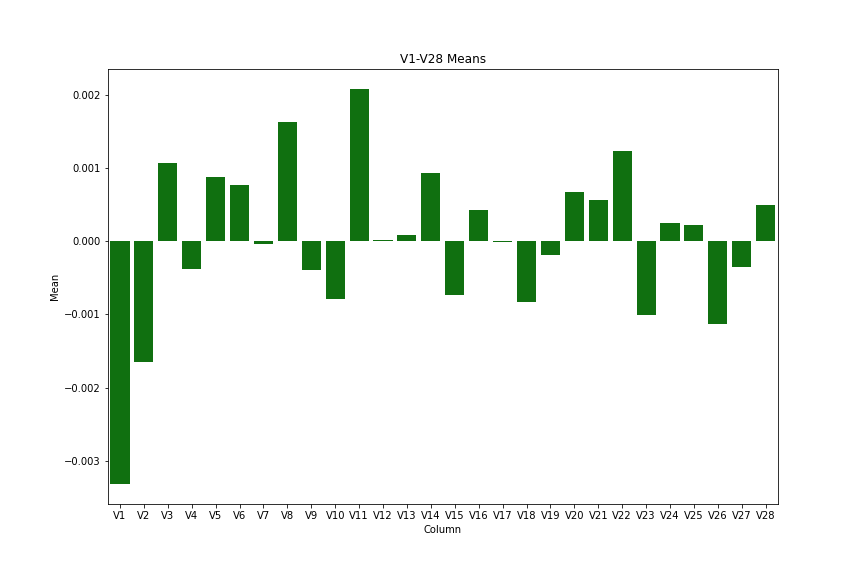

In [6]:
# plot the mean of v columns
plt.figure(figsize=(12,8))
sns.barplot(x=pca_vars, y=train_df[pca_vars].mean(), color='green')
plt.xlabel('Column')
plt.ylabel('Mean')
plt.title('V1-V28 Means')
plt.savefig('./images/eda_v1_v28_means.png')
plt.close()

display_image('./images/eda_v1_v28_means.png')

##### Observation:
> All of V1-V28 have approximately zero mean.


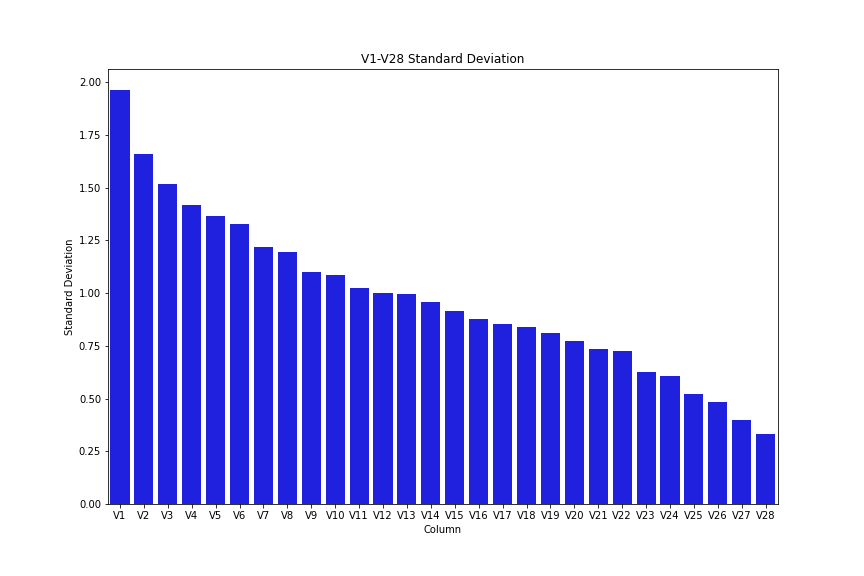

In [7]:
# plot the std of v colums
plt.figure(figsize=(12,8))
sns.barplot(x=pca_vars, y=train_df[pca_vars].std(), color='blue')
plt.xlabel('Column')
plt.ylabel('Standard Deviation')
plt.title('V1-V28 Standard Deviation')
plt.savefig('./images/eda_v1_v28_std.png')
plt.close()

display_image('./images/eda_v1_v28_std.png')

##### Observation:
> The PCA variables have unit variance, but as low as ~0.4 and as high as ~1.9


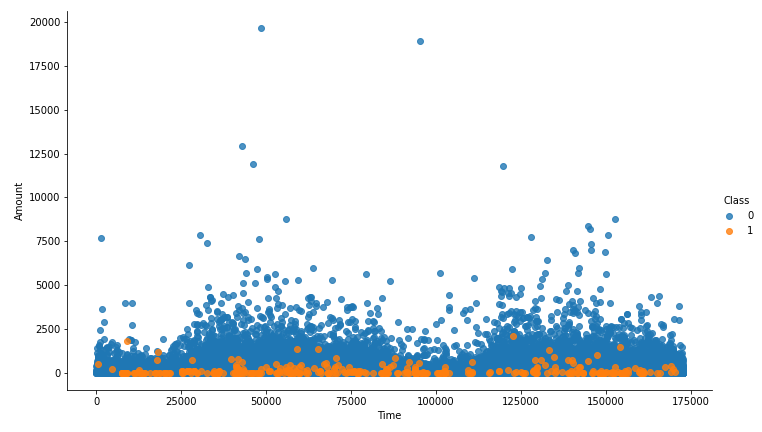

In [8]:
sns.lmplot('Time', 'Amount', train_df, hue='Class', fit_reg=False, height=6, aspect=10/6)
plt.savefig('./images/eda_time_amount_class.png')
plt.close()

display_image('./images/eda_time_amount_class.png')

##### Observation:
> 1. Doesn't seem like the time of transaction really matters.
> 2. Most of the fraud transactions are of low value

#### 2.0 Check the class count for each class. It’s a class Imbalance problem.

No Frauds 99.83 % of the dataset, count( 227451 )
Frauds 0.17 % of the dataset, count( 394 )



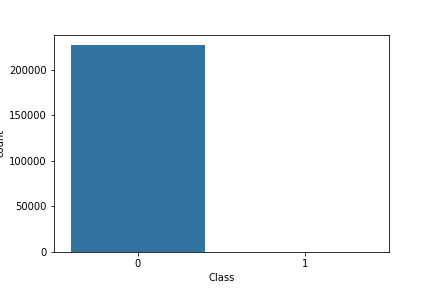

In [9]:
# see the class imbalance
def plot_class_balance(df, name):
    vc = df['Class'].value_counts()
    print('No Frauds', round(vc[0]/len(df) * 100,2), '% of the dataset, count(', vc[0], ')')
    print('Frauds', round(vc[1]/len(df) * 100,2), '% of the dataset, count(', vc[1], ')')
    sns.countplot(x="Class", data=df) 
    plt.savefig(f'./images/{name}.png')
    plt.close()
    
plot_class_balance(train_df, 'class_balance1')
display_image(f'./images/class_balance1.png')

##### Observation:
> Clearly the data is totally unbalanced!!

#### 3.0 Use techniques like undersampling or oversampling before running Naïve Bayes, Logistic Regression or SVM

In [10]:
X = train_df.iloc[:, train_df.columns != 'Class']
y = train_df.iloc[:, train_df.columns == 'Class']

In [11]:
def getSamplingF1Score(name, steps):
    # A traditional scikit-learn Pipeline cannot be used; instead, 
    # Pipeline from the imbalanced-learn library can be used
    pl = imPipeline(steps=steps)
    cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    scores = cross_val_score(pl, X, y, scoring='f1', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    print(f'{name} F1 Score: {score}')

In [12]:
# trying simple over sampling and under sampling
over = RandomOverSampler()
under = RandomUnderSampler()

getSamplingF1Score('GaussianNB :: Over-Sampling', [
    ('o', over), 
    ('model', GaussianNB())
])
getSamplingF1Score('GaussianNB :: Under-Sampling', [
    ('u', under), 
    ('model', GaussianNB())
])

GaussianNB :: Over-Sampling F1 Score: 0.20242011088007583
GaussianNB :: Under-Sampling F1 Score: 0.1952762483743985


Over-sampling increases the prior probability of imbalanced class and in case of other classifiers, error gets multiplied as the low-proportionate class is mimicked multiple times.

And also we can see Under-Sampling has a very low F1 score.

##### SMOTE Technique (Over-Sampling):
SMOTE stands for Synthetic Minority Over-sampling Technique. Unlike Random UnderSampling, SMOTE creates new synthetic points in order to have an equal balance of the classes. This is another alternative for solving the "class imbalance problems".

In [13]:
smote = SMOTE(sampling_strategy='minority')

getSamplingF1Score('GaussianNB :: SMOTE-Sampling', [
    ('s', smote), 
    ('model', GaussianNB())
])

GaussianNB :: SMOTE-Sampling F1 Score: 0.25555655924503556


No Frauds 50.0 % of the dataset, count( 227451 )
Frauds 50.0 % of the dataset, count( 227451 )



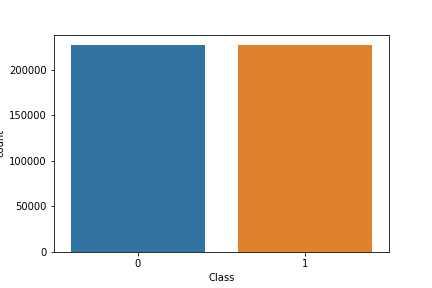

In [14]:
# finally smote the data
X_train_new, y_train_new = smote.fit_sample(X, y)
new_df = X_train_new.copy()
new_df['Class'] = y_train_new

plot_class_balance(new_df, 'class_balance2')
display_image(f'./images/class_balance2.png')

In [15]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454902 entries, 0 to 454901
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    454902 non-null  float64
 1   V1      454902 non-null  float64
 2   V2      454902 non-null  float64
 3   V3      454902 non-null  float64
 4   V4      454902 non-null  float64
 5   V5      454902 non-null  float64
 6   V6      454902 non-null  float64
 7   V7      454902 non-null  float64
 8   V8      454902 non-null  float64
 9   V9      454902 non-null  float64
 10  V10     454902 non-null  float64
 11  V11     454902 non-null  float64
 12  V12     454902 non-null  float64
 13  V13     454902 non-null  float64
 14  V14     454902 non-null  float64
 15  V15     454902 non-null  float64
 16  V16     454902 non-null  float64
 17  V17     454902 non-null  float64
 18  V18     454902 non-null  float64
 19  V19     454902 non-null  float64
 20  V20     454902 non-null  float64
 21  V21     45

#### 4.0 Following are the matrices for evaluating the model performance: Precision, Recall, F1-Score, AUC-ROC curve. Use F1-Score as the evaluation criteria for this project.

In [16]:
# since Time realy does not matter, lets drop the column now
new_df.drop(['Time'], inplace=True, axis=1)
test_df.drop(['Time'], inplace=True, axis=1)

# Amount is not scaled, so lets scale that colums
new_df['Amount'] = StandardScaler().fit_transform(new_df['Amount'].values.reshape(-1, 1))
test_df['Amount'] = StandardScaler().fit_transform(test_df['Amount'].values.reshape(-1, 1))

In [17]:
def plot_cf(y_test, y_pred, name):
    cm_nn=confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm_nn, annot=True, fmt = 'g', cmap="winter", cbar = False)
    plt.xlabel("Predicted Label", size = 18)
    plt.ylabel("True Label", size = 18)
    plt.title(f"{name} - Confusion Matrix", size = 20)
    plt.savefig(f'./images/{name}.png')
    plt.close()

def print_f1(y_test, y_pred):
    score = f1_score(y_test, y_pred)
    print(f'F1 Score: {score}')
    
def print_precision(y_test, y_pred):
    score = precision_score(y_test, y_pred)
    print(f'Precision Score: {score}')
    
def print_recall(y_test, y_pred):
    score = recall_score(y_test, y_pred)
    print(f'Recall Score: {score}')

def print_cf_f1(cls, X_test, y_test):
    cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    scores = cross_val_score(cls, X_test, y_test, scoring='f1', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    print(f'Cross Validation F1 Score: {score}')

In [18]:
X_train = new_df.iloc[:, new_df.columns != 'Class']
y_train = new_df.iloc[:, new_df.columns == 'Class']

X_test = test_df.iloc[:, test_df.columns != 'Class']
y_test = test_df.iloc[:, test_df.columns == 'Class']

In [19]:
# F1-Score for Naïve Bayes (GaussianNB)
cls_nb = GaussianNB()
cls_nb.fit(X_train, y_train)

y_pred = cls_nb.predict(X_test)
plot_cf(y_test, y_pred, 'GaussianNB')

print_f1(y_test, y_pred)
print_cf_f1(cls_nb, X_test, y_test)

F1 Score: 0.10645375914836991
Cross Validation F1 Score: 0.120777357956075



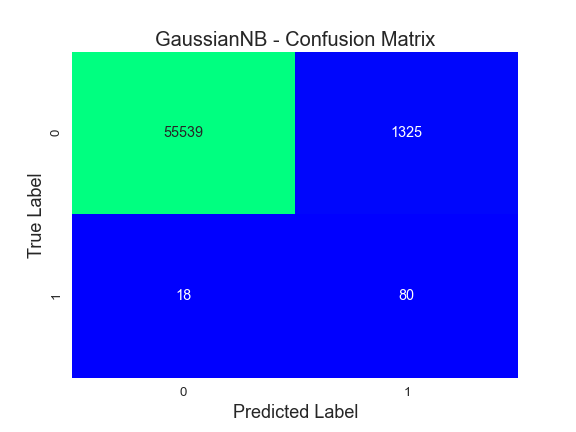

In [20]:
display_image('./images/GaussianNB.png')

In [21]:
# F1-Score for Logistic Regression (LogisticRegression)
cls_lr = LogisticRegression()
cls_lr.fit(X_train, y_train)

y_pred = cls_lr.predict(X_test)
plot_cf(y_test, y_pred, 'LogisticRegression')

print_f1(y_test, y_pred)
print_cf_f1(cls_lr, X_test, y_test)

F1 Score: 0.20500595947556613
Cross Validation F1 Score: 0.6652847805788982



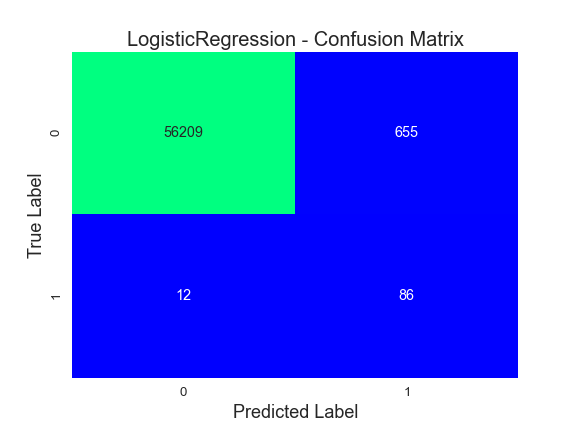

In [23]:
display_image('./images/LogisticRegression.png')

#### Project Task: Week 2

Modeling Techniques:

Try out models like Naive Bayes, Logistic Regression or SVM. Find out which one performs the best
Use different Tree-based classifiers like Random Forest and XGBoost. 
  1. Remember Tree-based classifiers work on two ideologies: Bagging or Boosting
  2. Tree-based classifiers have fine-tuning parameters which takes care of the imbalanced class. Random-Forest and XGBboost.

Compare the results of 1 with 2 and check if there is any incremental gain.

In [ ]:
# F1-Score for RandomForestClassifier (RandomForestClassifier)
pipeline_rf = Pipeline([
    ('model', RandomForestClassifier())
])
param_grid_rf = {
    'model__n_estimators': [10, 50, 150],
    'model__max_depth': [5, 25, None],
    'model__min_samples_leaf': [2, 4, 6],
    'model__min_samples_split': [5, 7, 10]
}

grid_rf = GridSearchCV(
    estimator=pipeline_rf, 
    param_grid=param_grid_rf, 
    scoring='f1', 
    n_jobs=-1, 
    pre_dispatch='2*n_jobs', 
    cv=5, 
    verbose=1, 
    return_train_score=False
)
grid_rf.fit(X_train, y_train)

y_pred = grid_rf.best_estimator_.predict(X_test)

plot_cf(y_test, y_pred, 'RandomForestClassifier')

print_f1(y_test, y_pred)
print_cf_f1(grid_rf.best_estimator_, X_test, y_test)

print("\nBest Param", grid_rf.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  7.4min


In [ ]:
display_image('./images/RandomForestClassifier.png')

In [ ]:
## F1-Score for XGBClassifier (XGBClassifier)
pipeline_xgb = Pipeline([
    ('model', XGBClassifier(objective='binary:logistic'))
])
param_grid_xgb = {
    'model_learning_rate': [0.01, 0.1, 0.5]
    'model__n_estimators': [100, 200, 500],
    'model__subsample': [0.3, 0.5, 0.9],
    'model__max_depth': [3, 6, 9],
    'model__colsample_bytree': [0.5, 0.7, 0.9],
    'model__min_child_weight': [1, 2, 3]
}

grid_xgb = RandomizedSearchCV(
    estimator=pipeline_xgb, 
    param_grid=param_grid_xgb, 
    scoring='f1', 
    n_jobs=-1, 
    pre_dispatch='2*n_jobs', 
    cv=5, 
    verbose=1, 
    return_train_score=False
)
grid_xgb.fit(X_train, y_train)

y_pred = grid_xgb.best_estimator_.predict(X_test)

plot_cf(y_test, y_pred, 'XGBClassifier')

print_f1(y_test, y_pred)
print_cf_f1(grid_xgb.best_estimator_, X_test, y_test)

print("\nBest Param", grid_xgb.best_params_)

In [ ]:
display_image(f'./images/XGBClassifier.png')

##### Observation:
> XGBClassifier we have highest cross validation f1 score

#### Project Task: Week 3

Applying ANN:

1. Use ANN (Artificial Neural Network) to identify fradulent and non-fradulent.
   1. Fine-tune number of layers
   2. Number of Neurons in each layers
   3. Experiment in batch-size
   4. Experiment with number of epochs. Check the observations in loss and accuracy
   5. Play with different Learning Rate variants of Gradient Descent like Adam, SGD, RMS-prop
   6. Find out which activation performs best for this use case and why?
   7. Check Confusion Matrix, Precision, Recall and F1-Score
2. Try out Dropout for ANN. How is it performed? Compare model performance with the traditional ML based prediction models from above. 
3. Find the best setting of neural net that can be best classified as fraudulent and non-fraudulent transactions. Use techniques like Grid Search, Cross-Validation and Random search.

Anomaly Detection:

4. Implement anomaly detection algorithms.
   1. Assume that the data is coming from a single or a combination of multivariate Gaussian
   2. Formalize a scoring criterion, which gives a scoring probability for the given data point whether it belongs to the multivariate Gaussian or Normal Distribution fitted in 1.

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import regularizers

In [ ]:
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [ ]:
INPUT_DIM = X_train.shape[1]

In [ ]:
def generate_model(optimizer=Adam(), init='glorot_uniform', activation='relu', dropout_rate=0.5, no_of_n=16, lr=0.001):
    # create model
    _model = Sequential()
    _model.add(Dense(32,input_dim = INPUT_DIM, activation = activation, kernel_initializer=init))
    _model.add(BatchNormalization())

    _model.add(Dense(no_of_n, activation = activation, kernel_initializer=init))
    _model.add(BatchNormalization())
    _model.add(Dropout(dropout_rate))

    _model.add(Dense(no_of_n, activation = activation, kernel_initializer=init))
    _model.add(BatchNormalization())
    _model.add(Dropout(dropout_rate))

    _model.add(Dense(1, activation = 'sigmoid'))
    
    optimizer.learning_rate.assign(lr)
        
    _model.compile(optimizer = optimizer, loss = 'binary_crossentropy')
    
    return _model

In [ ]:
model_sgd = generate_model(optimizer=SGD())

history_sgd = model_sgd.fit(X_train, y_train,
                    epochs=50,
                    batch_size=1000,
                    validation_split=0.4,
                    verbose=0).history

In [ ]:
model_adam = generate_model(optimizer=Adam())

history_adam = model_adam.fit(X_train, y_train,
                    epochs=50,
                    batch_size=1000,
                    validation_split=0.4,
                    verbose=0).history

In [ ]:
evaluation_metrics=pd.DataFrame(history_sgd)
evaluation_metrics.plot(figsize=(10,5))
plt.title("SGD Optimizer Training Loss vs Validation Loss", size = 20)
plt.savefig('./images/sgd.png')
plt.close()

display_image('./images/sgd.png')

In [ ]:
evaluation_metrics=pd.DataFrame(history_adam)
evaluation_metrics.plot(figsize=(10,5))
plt.title("Adam Optimizer Training Loss vs Validation Loss", size = 20)
plt.savefig('./images/adam.png')
plt.close()

display_image('./images/adam.png')

In [ ]:
y_pred = model_adam.predict_classes(X_test)

In [ ]:
print_f1(y_test, y_pred)
print_precision(y_test, y_pred)
print_recall(y_test, y_pred)

In [ ]:
plot_cf(y_test, y_pred, 'ANN')
display_image('./images/ANN.png')

##### Observation:
> If we compare this with the XGBoost or RandomForest model, the little problem here is that, it is doing better prediction for the majority class, which is 0 or "No Fraud" cases, but for minority class, which is 1 or "Fraud" cases, it is performing a little less. There are more number of legitimate transactions that is predicted as a fraud. But I guess with a little more hyperparamters tuning, the model will be able to perform better than the XGBoost or RandomForest even for minority class.

In [ ]:
model_ann = KerasClassifier(build_fn=generate_model, epochs=50, batch_size=1000, verbose=0)

epochs = [10, 50]
batches = [500, 1000]
init = ['glorot_normal', 'glorot_uniform']
activation = ['relu', 'tanh', 'sigmoid']
dropout_rate=[0.0, 0.3, 0.5] 
no_of_n=[32, 64, 128]
lr = [0.0001, 0.001]

param_grid_ann = dict(epochs=epochs, 
                      batch_size=batches, 
                      init=init, 
                      activation=activation, 
                      dropout_rate=dropout_rate, 
                      no_of_n=no_of_n,
                      lr=lr)

grid_ann = GridSearchCV(
    estimator=model_ann, 
    param_grid=param_grid_rf, 
    scoring='f1', 
    n_jobs=-1, 
    pre_dispatch='2*n_jobs', 
    cv=5, 
    verbose=1, 
    return_train_score=False
)
s
grid_ann.fit(X_train, y_train)

In [ ]:
y_pred = grid_ann.best_estimator_.predict(X_test)
print("\nBest Param", grid_ann.best_params_)

In [ ]:
plot_cf(y_test, y_pred, 'ANNBest')
display_image('./images/ANNBest.png')

In [ ]:
print_f1(y_test, y_pred)
print_precision(y_test, y_pred)
print_recall(y_test, y_pred)

#### Project Task: Week 4

Inference and Observations:

Visualize the scores for Fraudulent and Non-Fraudulent transactions.
Find out the threshold value for marking or reporting a transaction as fraudulent in your anomaly detection system.
Can this score be used as an engineered feature in the models developed previously? Are there any incremental gains in F1-Score? Why or Why not?
Be as creative as possible in finding other interesting insights.